Color Detection

We import the basic libraries including matplotlib.pyplot and numpy. 
To extract the count, we will use Counter from the collections library. 
To use OpenCV, we will use cv2. 
KMeans algorithm is part of the sklearn's cluster subpackage. To compare colors we first convert them to lab using rgb2lab and then calculate similarity using deltaE_cie76. Finally, to combine paths while reading files from a directory, we import os.

The type of this input is <class 'numpy.ndarray'>
Shape: (1050, 1400, 3)


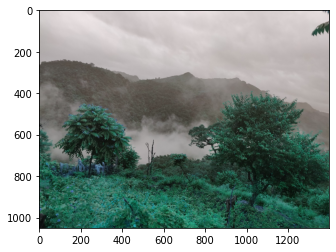

In [67]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os


image = cv2.imread('images/trees.jpeg')
print("The type of this input is {}".format(type(image)))
print("Shape: {}".format(image.shape))
plt.imshow(image)

The color of the image looks a bit off. This is because, by default, OpenCV reads image in the sequence Blue Green Red (BGR). Thus, to view the actual image we need to convert the rendering to Red Green Blue (RGB).


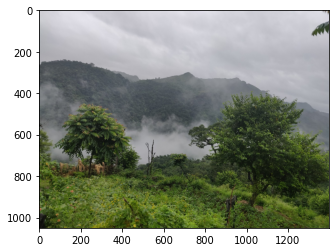

In [68]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In some situations, we might want to have black and white images. In such cases, we can express images as Gray. We now use the conversion space as cv2.COLOR_BGR2GRAY and show the output with the colormap as gray.

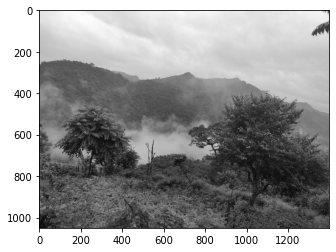

In [69]:

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')

We can also resize the image to a given dimension. We use the method resize provided by cv2. The first argument is the image we want to resize, and the second argument is the width and height defined within parentheses.

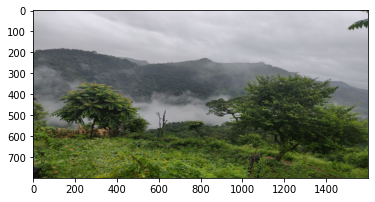

In [70]:
resized_image = cv2.resize(image, (1600, 800))
plt.imshow(resized_image)

Now moving on to identifying the colors from an image and displaying the top colors as a pie chart.

Color Identification : 

RGB to Hex Conversion -
We’d first define a function that will convert RGB to hex so that we can use them as labels for our pie chart.

In [71]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

Read image in RGB color space: 

Next, we define a method that will help us get an image into Python in the RGB space.

In [72]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

Get colors from an image : 

We now define the complete code as a method that we can call to extract the top colors from the image and display them as a pie chart. I’ve named the method as get_colors and it takes 3 arguments:

image: The image whose colors we wish to extract.

number_of_colors: Total colors we want to extract.

show_chart: A boolean that decides whether we show the pie chart or not.

In [73]:
modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

First, we resize the image to the size 600 x 400. It is not required to resize it to a smaller size but we do so to lessen the pixels which’ll reduce the time needed to extract the colors from the image. KMeans expects the input to be of two dimensions, so we use Numpy’s reshape function to reshape the image data.

In [74]:
clf = KMeans(n_clusters = 8)#number of colours
labels = clf.fit_predict(modified_image)

KMeans algorithm creates clusters based on the supplied count of clusters. In our case, it will form clusters of colors and these clusters will be our top colors. We then fit and predict on the same image to extract the prediction into the variable labels.

Here is final code for the above functions

[array([75.26651203, 77.34922944, 73.84455103]),
 array([196.21869268, 220.40245123, 176.23169918]),
 array([28.27501319, 28.50011066, 27.11101653]),
 array([132.47516439, 141.10038266, 124.62956496]),
 array([160.43812285, 172.85355137, 148.78605726]),
 array([231.30018598, 243.7715959 , 219.55094773]),
 array([47.21161122, 48.29191129, 46.61888454]),
 array([104.14271913, 109.03838294, 101.04124401])]

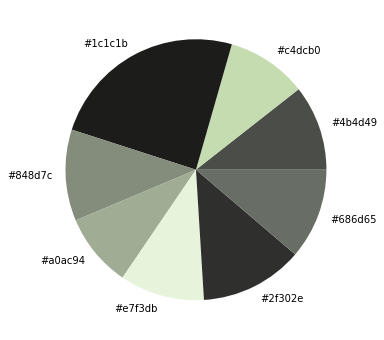

In [79]:
def get_colors(image, number_of_colors, show_chart):
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors
get_colors(get_image('images/farm-cat.jpg'), 8, True)

We’ve just identified the majority 8 colors that exist in our image. Let’s try and implement a search mechanism that can filter images based on the color supplied by us.

Search Images using color

We’ll now dive into the code of filtering a set of five images based on the color we’d like. For our use case, we’ll supply the RGB values for the colors Green, Blue and Yellow and let our system filter the images.

In [80]:
IMAGE_DIRECTORY = 'images'
COLORS = {
    'GREEN': [0, 128, 0],
    'BLUE': [0, 0, 128],
    'YELLOW': [255, 255, 0],
    'RED': [255, 0, 0],
    'ORANGE': [255, 127, 0]
}
images = []

for file in os.listdir(IMAGE_DIRECTORY):
    if not file.startswith('.'):
        images.append(get_image(os.path.join(IMAGE_DIRECTORY, file)))

The images are in the folder images. We define COLORS as a dictionary of colors. Then, we read all images in that folder and save their values in the images array.

Show all images

We first show all the images in the folder using the below mentioned for loop.

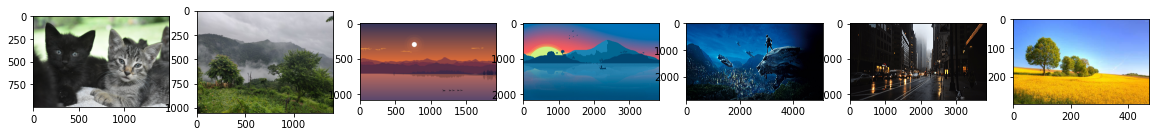

In [81]:
plt.figure(figsize=(20, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i])

Match Images with color

We now define a method match_image_by_color to filter all images that match the selected color.

In [84]:
def match_image_by_color(image, color, threshold = 60, number_of_colors = 10): 
    
    image_colors = get_colors(image, number_of_colors, False)
    selected_color = rgb2lab(np.uint8(np.asarray([[color]])))

    select_image = False
    for i in range(number_of_colors):
        curr_color = rgb2lab(np.uint8(np.asarray([[image_colors[i]]])))
        diff = deltaE_cie76(selected_color, curr_color)
        if (diff < threshold):
            select_image = True
    
    return select_image

We first extract the image colors using our previously defined method get_colors in RGB format. We use the method rgb2lab to convert the selected color to a format we can compare. The for loop simply iterates over all the colors retrieved from the image.

Show selected images

We define a function show_selected_images that iterates over all images, calls the above function to filter them based on color and displays them on the screen using imshow.

In [85]:
def show_selected_images(images, color, threshold, colors_to_match):
    index = 1
    
    for i in range(len(images)):
        selected = match_image_by_color(images[i],color,threshold,colors_to_match)
        if (selected):
            plt.subplot(1, 5, index)
            plt.imshow(images[i])
            index += 1

Filter Results

We call the method as follows. We will just replace the variable selected_color with COLORS['GREEN'] for Green, COLORS['BLUE'] for Blue, and COLORS['YELLOW'] for Yellow. We set the threshold value to be 60 and total colors to be extracted from image to be 5

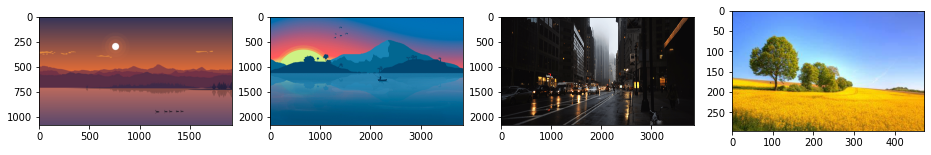

In [86]:
# Variable 'selected_color' can be any of COLORS['GREEN'], COLORS['BLUE'] or COLORS['YELLOW']
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['ORANGE'], 60, 6)